# Pose Prediction From Smartwatch Data
### Part 1

Welcome, this notebook is the first chapter of the hackathon challenge to predict human arm pose from the sensor data of a single smartwatch. In other words, a human wears a smartwatch, and we will try to predict their arm pose from the sensor outputs we can read from the watch.

## A Dive Into The Dataset

In this first chapter, we will have a detailed look into the data and how to interpret it. You will also be presented with an in-depth Exploratory Data Analysis (EDA) process for covering various essential steps in data preprocessing. The training of predictive models comes afterward. The following sections guide you step-by-step through convenience functions for reading, plotting, normalizing, and storing the data for future use.


### Coordinate Systems and Data Columns

There are two reference coordinate frames this data comes in. The goal of this project is to predict the human arm pose from smartwatch data. 

#### Shoulder Reference Frame

All human arm pose data comes in the coordinate system depicted below. The data is in reference to the human shoulder, with the X-axis to the right, the Y-axis up, and the Z-axis in forward-facing direction. 

Our hand or elbow positions as well as orientations come in this reference frame. This means, if the hand position is `(-0.1, 0.5, 0.0)`, then it is 10cm to the left of the shoulder, 50cm in front of the shoulder, and exactly at the same height as the shoulder. 

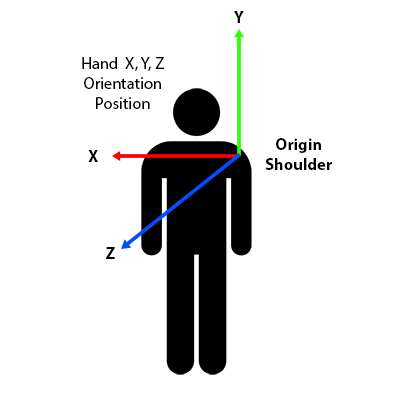

The data columns in this reference frame are:
* `gt_hand_orig_rua` hand origin (wrist) position in XYZ
* `gt_larm_6drr_rh` lower arm orientation in a 6-dimensional rotation representation
* `gt_larm_orig_rua` lower arm origin (elbow) position in XYZ
* `gt_uarm_6drr_rh` upper arm orientation in a 6-dimensional rotation representation
* `sw_6drr_cal` calibrated smartwatch orientation in a 6-dimensional rotation representation

#### Watch Reference Frame

The second coordinate system is in reference to the watch with Z-axis emanating from the watch, perpendicular to the surface. When worn on the left hand, the Y-axis points along the watch surface forwards and the X-axis to the right of the watch.

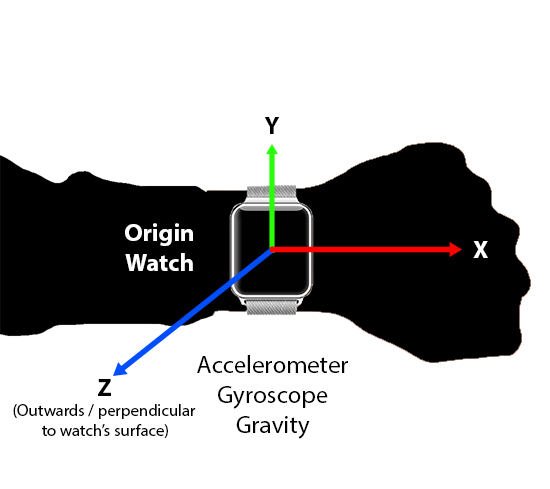

The data columns in this reference frame are:
* `sw_gyro` gyroscope measurements (angular velocities)
* `sw_lvel` translational velocity
* `sw_lacc`	translational acceleration (without gravity)
* `sw_grav`	gravity measurements


#### Remaining Data Columns

The remaining data columns do not have a particular reference frame:

* `sw_pres_cal` calibrated atmospheric pressure relative to chest position
* `sw_dt` time since last observation	
* `sw_h : sw_m : sw_s : sw_ns` observation timestamp

### 0. Downloading Dependencies (Optional)

We begin by downloading the libraries we will be using in this notebook. If you have all of these pre-installed, you may skip this step.

In [ ]:
!pip install numpy
!pip install pandas
!pip install os
!pip install matplotlib
!pip install plotly

### 1. Importing Libraries
Let's import the dependencies. The last import aims to import the `config.py` file from the root directory of this project. This file stores path variables to where the data is located on your system. If you have not created the file, copy the `default_config.py` file in your project root, rename it into `config.py` and adjust the "data_path" entry within.

In [17]:
import numpy as np
import pandas as pd
import os

# Plotting tools
import matplotlib.pyplot as plt
import plotly.graph_objs as go
import config       # adjust data paths in config.py

### 2. Loading Raw Data

Time for us to load the raw dataset into the notebook environment. You will notice multiple files in the data folder as we recorded the data in different instances over a few days. Since all the attributes in the various files are the same, wouldn't it be better to have all of them in a single file? 

Note: Make sure to update the `config.py` file.

In [18]:
"""
    Loading the data set from the appropriate path and combining different files into one data frame
"""

path = config.paths["data_path"]

csv_files = [file for file in os.listdir(path) if file.endswith('.csv')]

data_list = []
for csv_file in csv_files:
    file_path = os.path.join(path, csv_file)
    df = pd.read_csv(file_path)
    data_list.append(df)

data_raw = pd.concat(data_list, ignore_index=True)

### 3. Plotting Functions

The chapter aims to help you visualize and identify possible linkages that show a strong or weak relationship between the different features (or columns). With the help of some modular functions, let's get a step closer to visualizing data.

Feel free to use these functions to investigate the data to interpret the linkage between additional columns/features.

In [26]:
"""
    This section represents all the functions required for various visualizations:
        - The output_visualization function represents the X, Y, Z coordinates in a non-interactive graph.
        - The interactive_output_visualization function helps in visualizing the X, Y, Z coordinates in an interactive 3D map. 
        - The distributionPlot function visualizes the 6 (or 1) different features. 
        - The correlationPlot function takes two features and graphically represents the correlation between them. 
"""


# Helper function that provides appropriate the approriate length for columns.
# The duration variable helps in defining the length of continuous data - this helps in visualizing a smaller hand trajectory 
# The randomseed variable helps to visualize the same data without randomizing the selection process
# The remaining functions follow the same variables and analogy
def data_columns(data, duration=None, randomseed=False):
    dim1, dim2, dim3 = np.array(data['gt_hand_orig_rua_x']), np.array(data['gt_hand_orig_rua_y']), np.array(
        data['gt_hand_orig_rua_z'])

    if duration is not None:
        if randomseed:
            np.random.seed(42)
        else:
            np.random.seed(None)
        reduced_samples = 10 * duration
        start_index = np.random.choice(len(dim1) - reduced_samples + 1)
        dim1 = dim1[start_index: start_index + reduced_samples]
        dim2 = dim2[start_index: start_index + reduced_samples]
        dim3 = dim3[start_index: start_index + reduced_samples]

    return dim1, dim2, dim3


def output_visualization(data, duration=None, randomseed=False):
    fig = plt.figure(figsize=(10, 5))

    dim1, dim2, dim3 = data_columns(data)
    ax = fig.add_subplot(121, projection='3d')
    ax.scatter(dim1, dim2, dim3, c='b', marker='.', s=1, alpha= 0.01)
    ax.set_xlabel('X-Dimension')
    ax.set_ylabel('Y-Dimension')
    ax.set_zlabel('Z-Dimension')
    ax.set_title('X-Y-Z Coordinates (all) in 3D Space')

    dim1, dim2, dim3 = data_columns(data, duration, randomseed)
    ax = fig.add_subplot(122, projection='3d')
    ax.scatter(dim1, dim2, dim3, c='b', marker='o', s=5, alpha= 0.8)
    ax.set_xlabel('X-Dimension')
    ax.set_ylabel('Y-Dimension')
    ax.set_zlabel('Z-Dimension')
    ax.set_title('X-Y-Z Coordinates (some) in 3D Space')

    plt.tight_layout()
    plt.show()


def interactive_output_visualization(data, duration=None, randomseed=False):
    if duration:
        marker = dict(size=2, color='blue', opacity=0.8)
    else:
        marker = dict(size=1, color='blue', opacity=0.01)

    
    dim1, dim2, dim3 = data_columns(data, duration, randomseed)

    trace = go.Scatter3d(x=dim1, y=dim2, z=dim3, mode='markers', marker=marker,
                         name="Input Points")
    title = 'Values in 3D Space'
    layout = go.Layout(title=title, scene=dict(xaxis=dict(title='X-Dimension'),
                                               yaxis=dict(title='Y-Dimension'),
                                               zaxis=dict(title='Z-Dimension')))
    fig = go.Figure(data=[trace], layout=layout)
    fig.show()


def pltshow(x_lable, y_label, title, legend=False):
    plt.xlabel(x_lable)
    plt.ylabel(y_label)
    plt.title(title)
    if legend == True:
        plt.legend()
    plt.show()


def correlationPlot(data, label1="sw_pres_cal", label2="gt_hand_orig_rua_y"):
    dim1, dim2 = np.array(data[label1]), np.array(data[label2])

    plt.scatter(dim1, dim2, c='b', marker='.', s=0.2, alpha=0.2, label="observation")
    pltshow(f"{label1}", f"{label2}", f"Correlation between {label1} & {label2}", legend=True)


# The columns variable can be a list of strings (column names) or a string with a column name
def distributionPlot(data,
                     columns=["sw_6drr_cal_1", 'sw_gyro_x', 'sw_lvel_x', "sw_lacc_x", 'sw_grav_x', 'sw_pres_cal']):
    if type(columns) != str and len(columns) > 1:
        fig, axes = plt.subplots(2, 3, figsize=(10, 5))

        for i, column_name in enumerate(columns):
            row = i // 3
            col = i % 3

            values = data[column_name]
            axes[row, col].hist(values, bins='auto', density=True, alpha=0.4, color='b', label="observation")
            axes[row, col].set_xlabel(column_name)
            axes[row, col].set_ylabel('Density')
            axes[row, col].set_title('Distribution of ' + column_name)

        plt.tight_layout()
        plt.show()
    else:
        values = data[columns]

        plt.hist(values, bins='auto', density=True, alpha=0.4, color='b')
        pltshow(columns, 'Density', 'Distribution of ' + columns)

### 4. Plots with Raw Data

Let's visualize and interact with the data. 
- Top-left plot: Represents the entire X, Y & Z coordinates in the dataset
- Top-right plot: Represents a small trajectory of the hand movement
- Bottom plot: Allows you to interact in the 3D space - making more sense on the hand movement. Just click and drag on the plot to view in different angles. 

We recommend uncommenting line 4 in the following code block to visualize the XYZ hand positions of the entire dataset. Since there are over 510,000 data points, it takes some time to display the plot.

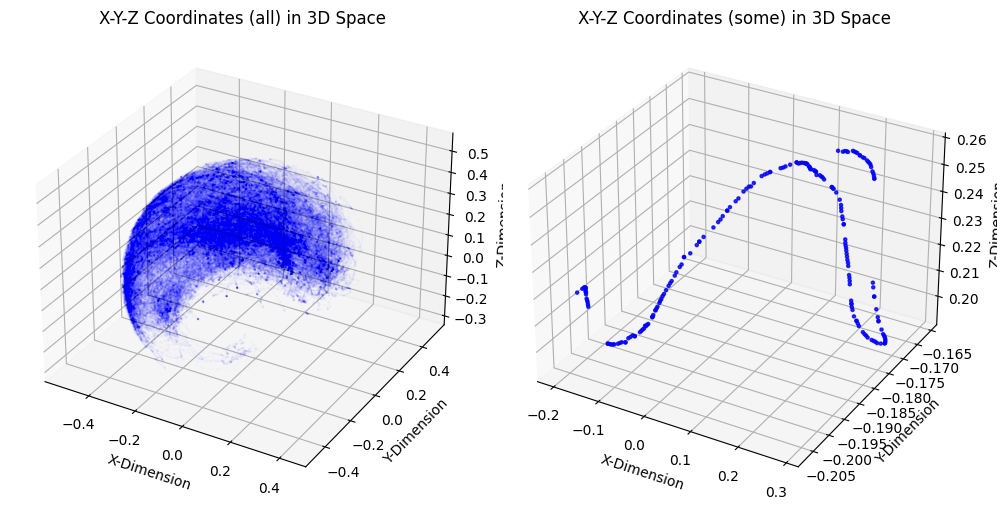

In [20]:
duration = 20       # The duration variable can only have integer values. You may update to visualize different lengths of trajectories
output_visualization(data_raw, duration=duration, randomseed=False)

# interactive_output_visualization(data_raw)    # Uncomment this to view the entire X,Y,Z hand coordinates of the dataset
interactive_output_visualization(data_raw, duration=duration, randomseed=False)

Notice here that the raw data's distribution is centered around 0. This aids in assessing that the dataset adheres to certain statistical distributions. Can you notice some deviations and outliers in these graphs?

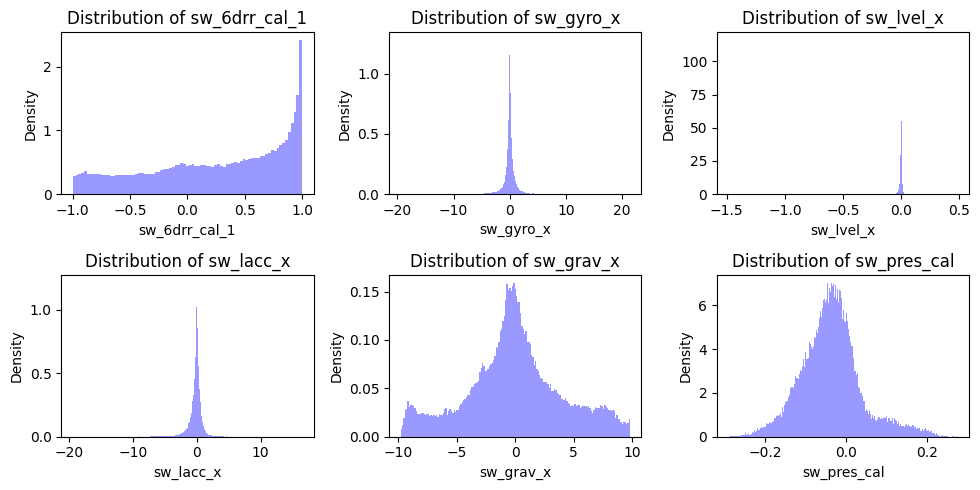

In [21]:
distributionPlot(data_raw)

The following correlation graphs indicate that there might be a close linkage between pressure and ground truth hand origin (relative to the upper arm) Y. 
Conversely, we can notice that there seems to be no linkage at all between the smart watch's gravity and linear acceleration in the x directions. 

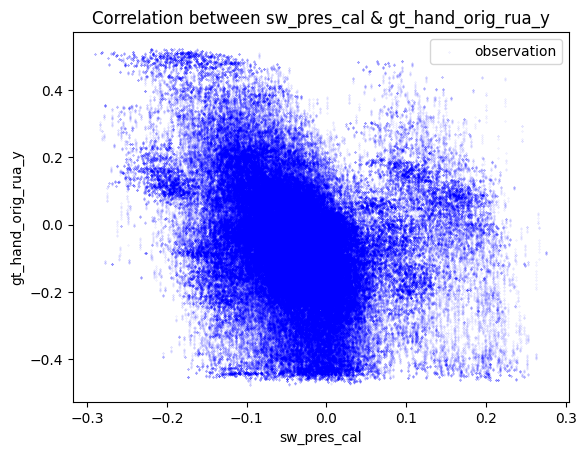

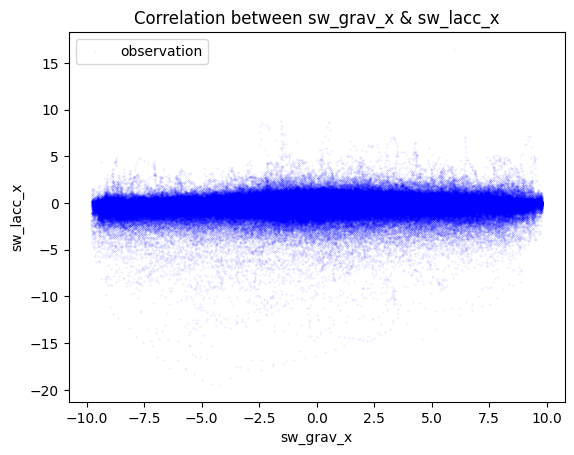

In [27]:
correlationPlot(data_raw)
correlationPlot(data_raw, label1="sw_grav_x", label2="sw_lacc_x")

### 5. Normalization

This part normalizes the data and locally stores it with means and standard deviations. We normalize by subtracting the mean and dividing by the standard deviation. Finally, we save this data locally as we need it in future notebooks.

At the end of this section, we check the data distribution plots of the normalized data and investigate the difference in the distribution plots of the raw data files.

In [23]:
gt_columns = [
    "gt_hand_orig_rua_x", "gt_hand_orig_rua_y", "gt_hand_orig_rua_z",
    "gt_larm_6drr_rh_1", "gt_larm_6drr_rh_2", "gt_larm_6drr_rh_3",
    "gt_larm_6drr_rh_4", "gt_larm_6drr_rh_5", "gt_larm_6drr_rh_6",
    "gt_larm_orig_rua_x", "gt_larm_orig_rua_y", "gt_larm_orig_rua_z",
    "gt_uarm_6drr_rh_1", "gt_uarm_6drr_rh_2", "gt_uarm_6drr_rh_3",
    "gt_uarm_6drr_rh_4", "gt_uarm_6drr_rh_5", "gt_uarm_6drr_rh_6"
]

sw_columns = [
    "sw_dt",
    "sw_gyro_x", "sw_gyro_y", "sw_gyro_z",
    "sw_lvel_x", "sw_lvel_y", "sw_lvel_z",
    "sw_lacc_x", "sw_lacc_y", "sw_lacc_z",
    "sw_grav_x", "sw_grav_y", "sw_grav_z",
    "sw_6drr_cal_1", "sw_6drr_cal_2", "sw_6drr_cal_3",
    "sw_6drr_cal_4", "sw_6drr_cal_5", "sw_6drr_cal_6",
    "sw_pres_cal"
]

# filter the columns of interest from the raw data file
data_raw_cs = data_raw.loc[:, gt_columns + sw_columns]

# get means and std of every column
raw_means = data_raw_cs.mean()
raw_stds = data_raw_cs.std()

# we normalize by subtracting the mean and dividing by the std
normalized_data = (data_raw_cs - raw_means) / raw_stds

# combine mean and std into one DataFrame
means_stds_df = pd.concat([raw_means, raw_stds], axis=1)

# create the cache directory if it doesn't exist yet
cache_path = config.paths["cache_path"]
if not cache_path.exists():
    cache_path.mkdir(parents=True)

# store normalized data as well as created means and stds for later use during training and testing
normalized_data.to_csv(cache_path / 'normalized_data.csv', index=False)
means_stds_df.to_csv(cache_path / 'means_stds.csv', index_label='Column')
print(f"Stored normalized data to: {cache_path}")

Stored normalized data to: /home/fabian/Documents/code/p_and_g_hackathon/cache


Now, you have normalized the data and stored it in the cache directory in your project root. Let us have a look at the distribution plots again. The scales should have changed, and distinct data columns should now be in similar value ranges.

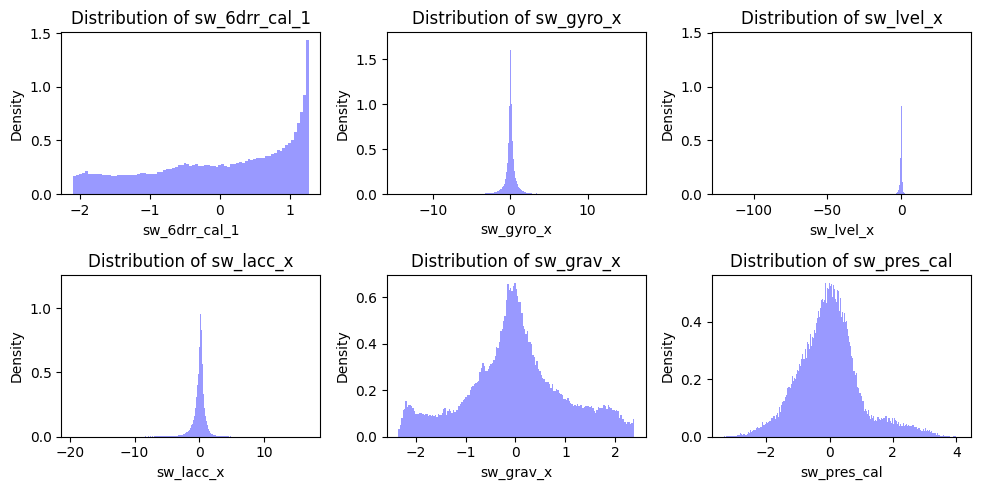

In [24]:
distributionPlot(normalized_data)